## Preparing Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os 


In [0]:
file_names = os.listdir('/content/train')
categories = []
for file_name in file_names:
    category = file_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': file_names,
    'category': categories
})

In [0]:
df.head(5)

,filename,category
0,dog.10998.jpg,1
1,dog.11240.jpg,1
2,cat.643.jpg,0
3,cat.11525.jpg,0
4,cat.10596.jpg,0


Image Size1 ,mode: (279, 499) ,RGB
Image Size2 ,mode: (359, 297) ,RGB
Image Size3 ,mode: (274, 183) ,RGB
Images are of different shape


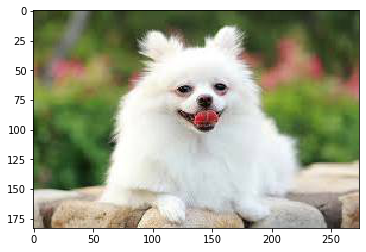

In [0]:
from keras.preprocessing.image import load_img

i=0
sample = random.choices(file_names,k=3)
for sample in sample:
  i=i+1
  image = load_img('/content/train/'+sample)
  print('Image Size{} ,mode: {} ,{}'.format(i,image.size,image.mode)) 
plt.imshow(image)  
print('Images are of different shape')

In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [0]:
print(df['category'].value_counts())
print('1:dogs  2:cats')

1    12500
0    12500
Name: category, dtype: int64
1:dogs  2:cats


# CNN Model Building

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'}) 

In [0]:
#splitting Data
from sklearn.model_selection import train_test_split

train_data, validate_data = train_test_split(df, test_size=0.20, random_state=21)
train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)

In [0]:
print(train_data.head(5))
print(train_data['category'].value_counts())
print(validate_data['category'].value_counts())

       filename category
0  dog.7650.jpg      dog
1  cat.4468.jpg      cat
2  cat.3460.jpg      cat
3   dog.464.jpg      dog
4  dog.6050.jpg      dog
cat    10054
dog     9946
Name: category, dtype: int64
dog    2554
cat    2446
Name: category, dtype: int64


#Data Agumentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=100
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_data, 
    '/content/train/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [0]:
temp = train_data.sample(1).reset_index(drop=True)

In [0]:
temp_generator = train_datagen.flow_from_dataframe(
    temp, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


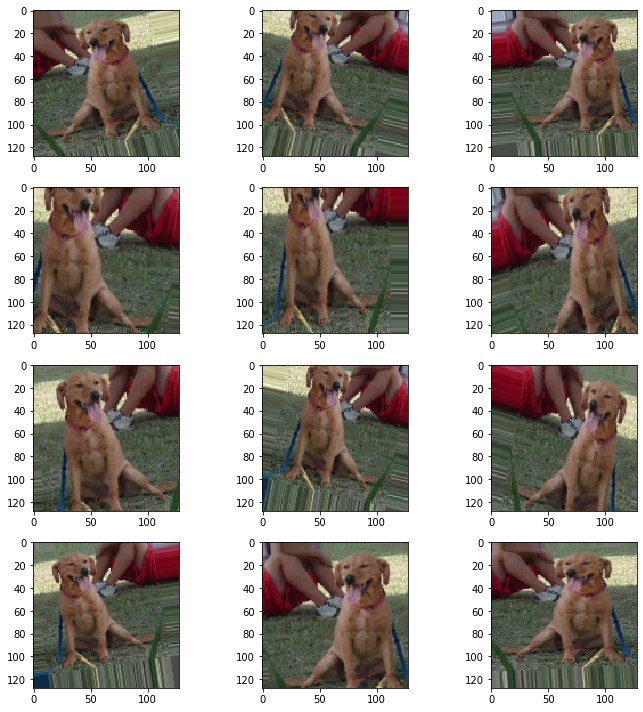

In [0]:
plt.figure(figsize=(10, 10))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in temp_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [0]:
validate_datagen = ImageDataGenerator(
    rescale=1./255
)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_data, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                              patience=3, min_lr=0.0001)

callbacks = [early_stop, reduce_lr]

In [0]:
# History.history attribute is a record of training loss values and metrics values at
# successive epochs, as well as validation loss values and validation metrics values (if applicable)
history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=validate_generator,
    validation_steps=validate_data.shape[0]//batch_size,
    steps_per_epoch=train_data.shape[0]//batch_size,
    callbacks=callbacks
)

Epoch 1/50
200/200 [==============================] - 137s 685ms/step - loss: 0.8047 - acc: 0.6309 - val_loss: 0.6824 - val_acc: 0.6836
Epoch 2/50
200/200 [==============================] - 130s 649ms/step - loss: 0.5617 - acc: 0.7219 - val_loss: 0.6639 - val_acc: 0.7208
Epoch 3/50
200/200 [==============================] - 130s 648ms/step - loss: 0.4682 - acc: 0.7789 - val_loss: 0.4031 - val_acc: 0.8126
Epoch 4/50
200/200 [==============================] - 129s 646ms/step - loss: 0.4298 - acc: 0.8023 - val_loss: 0.6003 - val_acc: 0.7614
Epoch 5/50
200/200 [==============================] - 129s 643ms/step - loss: 0.3978 - acc: 0.8191 - val_loss: 0.3831 - val_acc: 0.8402
Epoch 6/50
200/200 [==============================] - 129s 645ms/step - loss: 0.3684 - acc: 0.8362 - val_loss: 0.4588 - val_acc: 0.7880
Epoch 7/50
200/200 [==============================] - 129s 643ms/step - loss: 0.3502 - acc: 0.8457 - val_loss: 0.4706 - val_acc: 0.8140
Epoch 8/50
200/200 [============================

Train Accuracy      : 91.37% <br>
Validation Accuracy : 92.82

In [0]:
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']



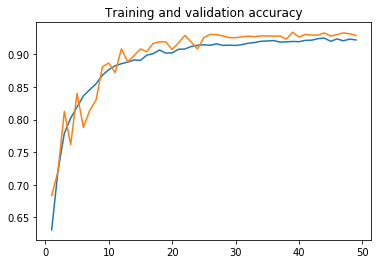

In [0]:
epochs=np.arange(1, 50, 1)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.show()

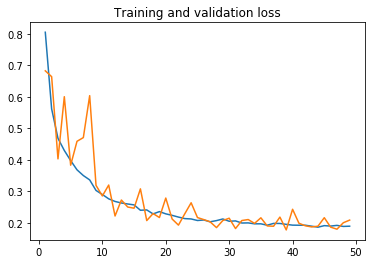

In [0]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.show()

# Test Data Prediction

In [0]:
test_filenames = os.listdir('/content/test1/')
test_data = pd.DataFrame({
    'filename': test_filenames
})


In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_data, 
    '/content/test1/', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
predict = model.predict_generator(test_generator, steps=test_data.shape[0]//batch_size)

In [0]:
print(predict.shape)

(12500, 2)


In [0]:
head=np.argmax(predict, axis=1)[0:6]
tail=np.argmax(predict, axis=1)[-6:]
labels=list(head)+list(tail)
print(labels)

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]


['11019.jpg', '2345.jpg', '5008.jpg', '481.jpg', '3939.jpg', '2939.jpg', '6766.jpg', '550.jpg', '4874.jpg', '7261.jpg', '2509.jpg', '263.jpg']


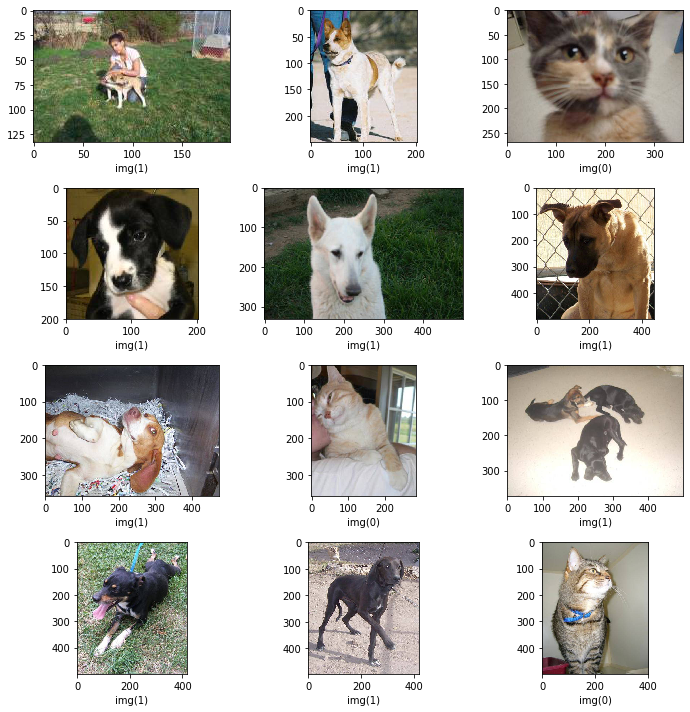

In [0]:
images=list(test_data['filename'].head(6))+list(test_data['filename'].tail(6))
print(images)
plt.figure(figsize=(10, 10))
i=0
for img in images:
    plt.subplot(4, 3, i+1)
    image = load_img('/content/test1/'+img)
    plt.imshow(image)
    plt.xlabel('img({})'.format(labels[i]))
    i=i+1
plt.tight_layout()
plt.show()

# Transfer Learning Model (VGG16)

In [0]:
from keras.applications import VGG16

model=VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model.summary()

Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________

In [0]:
import os
import pandas as pd

file_names = os.listdir('/content/train')
categories = []
for file_name in file_names:
    category = file_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': file_names,
    'category': categories
})

In [0]:
df.head(5)

,filename,category
0,dog.10998.jpg,1
1,dog.11240.jpg,1
2,cat.643.jpg,0
3,cat.11525.jpg,0
4,cat.10596.jpg,0


In [0]:
from keras_preprocessing.image import load_img,img_to_array
import numpy as np

count=0
features=list()
img='cat.5708.jpg'
img=load_img('/content/train/'+img, target_size=(128, 128))
img=img_to_array(img)
img=np.expand_dims(img, axis=0)
print(img.shape)
feature=model.predict(img)
print(feature.shape)
for img in file_names:
    img=load_img('/content/train/'+img, target_size=(128, 128))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    feature=model.predict(img)
    features.append(feature)
    count+=1
    if count%2500==0:
        print("[INFO]:{} images loaded".format(count))

(1, 128, 128, 3)
(1, 4, 4, 512)
[INFO]:2500 images loaded
[INFO]:5000 images loaded
[INFO]:7500 images loaded
[INFO]:10000 images loaded
[INFO]:12500 images loaded
[INFO]:15000 images loaded
[INFO]:17500 images loaded
[INFO]:20000 images loaded
[INFO]:22500 images loaded
[INFO]:25000 images loaded


In [0]:
features=np.array(features)
print('Before reshape,features.shape:',features.shape)

features=features.reshape(features.shape[0], 4*4*512)
print('After reshape, features.shape:',features.shape)

Before reshape,features.shape: (25000, 1, 4, 4, 512)
After reshape, features.shape: (25000, 8192)


In [0]:
from sklearn.model_selection import train_test_split

X=features
y=df['category']


X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression(solver="lbfgs",max_iter=100)
LR.fit(X_train, y_train)
y_pred=LR.predict(X_test)
print("Prediction Done!")

Prediction Done!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
 from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('Accuracy : ',accuracy_score(y_test, y_pred))
print('Confusion Matrix :\n',confusion_matrix(y_test, y_pred))
print('Classification Report :\n',classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

Accuracy :  0.9304
Confusion Matrix :
 [[2319  172]
 [ 176 2333]]
Classification Report :
               precision    recall  f1-score   support

         Cat       0.93      0.93      0.93      2491
         Dog       0.93      0.93      0.93      2509

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000

